<a href="https://colab.research.google.com/github/gibsonx/CE888/blob/master/Assignment/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U tensorflow zhon transformers sentencepiece
!git clone https://github.com/cardiffnlp/tweeteval.git
!git clone https://github.com/gibsonx/grocery.git

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/dist-packages (2.4.1)
     |████████████████████████████████| 102kB 4.5MB/s 
     |████████████████████████████████| 2.1MB 7.4MB/s 
     |████████████████████████████████| 1.2MB 22.1MB/s 
     |████████████████████████████████| 3.3MB 37.6MB/s 
     |████████████████████████████████| 901kB 55.2MB/s 
  Created wheel for zhon: filename=zhon-1.1.5-cp37-none-any.whl size=84291 sha256=dffce0d894d9a3716f4c46fe38c6e59fc235864efbf6a1e0c2af5de81dd4d08e
  Stored in directory: /root/.cache/pip/wheels/0e/93/5a/ad2f403c359ba996e33c21bf18611d921413df9740ede2fcf4
Successfully built zhon
Cloning into 'tweeteval'...
remote: Enumerating objects: 341, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 341 (delta 5), reused 10 (delta 1), pack-reused 318
Receiving objects: 100% (341/341), 10.78 MiB | 17.55 MiB/s, done.
Resolving deltas: 100% (96/96), done.
Cloning into 'groc

In [2]:
import re,os,string,sys
import pandas as pd
import csv
from zhon import hanzi
import itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input, layers, losses, preprocessing, utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Dense
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score
from zhon import hanzi
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

sys.path.insert(0, '/content/grocery/')
from CE888_Transformer import DataPrep, imbalance_under_sampling , create_model, get_tokenization, warmup
from CustomizedPlots import *
try:
    %tensorflow_version 2.x
except Exception:
    pass
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


#Data nominalization for training , validation and test datasets (Hate, Irony and Offensive)

In [3]:
#Define the root folder where we put the datasets
base_dir = '/content/tweeteval/datasets/'

#Create hate dataframe
hate = DataPrep(base_dir, 'hate') 
hate_dict_train, hate_dict_val, hate_dict_test = hate.dataframe()
df_hate = hate.dataframe_merge()
not_hate, hate = hate.binary_split()

#Create irony dataframe
irony = DataPrep(base_dir, 'irony') 
irony_dict_train, irony_dict_val, irony_dict_test = irony.dataframe()
df_irony = irony.dataframe_merge()
not_irony, irony = irony.binary_split()

#Create offensive dataframe
offensive = DataPrep(base_dir, 'offensive')
offensive_dict_train, offensive_dict_val, offensive_dict_test = offensive.dataframe()
df_offensive = offensive.dataframe_merge()
not_offensive, offensive = offensive.binary_split()

In [4]:
hate_dict_train = imbalance_under_sampling(hate_dict_train)
irony_dict_train = imbalance_under_sampling(irony_dict_train)
offensive_dict_train = imbalance_under_sampling(offensive_dict_train)

label 1 is more 1    3783
0    3783
Name: label, dtype: int64
label 0 is more 1    1417
0    1417
Name: label, dtype: int64
label 1 is more 1    3941
0    3941
Name: label, dtype: int64


#Downloading Models and Tokenizations from HuggingFace

In [5]:
from transformers import TFXLNetModel, XLNetTokenizer, TFDistilBertModel, DistilBertTokenizer

xlnet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
xlnet_model = TFXLNetModel.from_pretrained('xlnet-base-cased')

dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

for layer in xlnet_model.layers:
    layer.trainable = True
for layer in dbert_model.layers:
    layer.trainable = True

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


#CallBacks for all attempts of training

In [6]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, min_delta=0.001, restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(warmup, verbose=0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=1e-6, patience=2, verbose=0, mode='auto', min_delta=0.001, cooldown=0, min_lr=1e-6)
]

#Word Embeddings using XLNet tokenizier, inputs include Tokens and Attention masks

In [7]:
#DistilBert
dl_hate_train_input = get_tokenization(hate_dict_train['text'], dbert_tokenizer)
dl_hate_val_input = get_tokenization(hate_dict_val['text'], dbert_tokenizer)
dl_hate_test_input = get_tokenization(hate_dict_test['text'], dbert_tokenizer)

dl_irony_train_input = get_tokenization(irony_dict_train['text'], dbert_tokenizer)
dl_irony_val_input = get_tokenization(irony_dict_val['text'], dbert_tokenizer)
dl_irony_test_input = get_tokenization(irony_dict_test['text'], dbert_tokenizer)

dl_offensive_train_input = get_tokenization(offensive_dict_train['text'], xlnet_tokenizer)
dl_offensive_val_input = get_tokenization(offensive_dict_val['text'], xlnet_tokenizer)
dl_offensive_test_input = get_tokenization(offensive_dict_test['text'], xlnet_tokenizer)

#XLNet
xl_hate_train_input = get_tokenization(hate_dict_train['text'], xlnet_tokenizer)
xl_hate_val_input = get_tokenization(hate_dict_val['text'], xlnet_tokenizer)
xl_hate_test_input = get_tokenization(hate_dict_test['text'], xlnet_tokenizer)

xl_irony_train_input = get_tokenization(irony_dict_train['text'], xlnet_tokenizer)
xl_irony_val_input = get_tokenization(irony_dict_val['text'], xlnet_tokenizer)
xl_irony_test_input = get_tokenization(irony_dict_test['text'], xlnet_tokenizer)

xl_offensive_train_input = get_tokenization(offensive_dict_train['text'], xlnet_tokenizer)
xl_offensive_val_input = get_tokenization(offensive_dict_val['text'], xlnet_tokenizer)
xl_offensive_test_input = get_tokenization(offensive_dict_test['text'], xlnet_tokenizer)

print("The sample of tokenizations is shown below:")
xl_offensive_test_input

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `t

The sample of tokenizations is shown below:


(array([[    5,     5,     5, ...,    99,     4,     3],
        [    5,     5,     5, ...,   110,     4,     3],
        [    5,     5,     5, ...,  5277,     4,     3],
        ...,
        [    5,     5,     5, ..., 13336,     4,     3],
        [    5,     5,     5, ...,  4177,     4,     3],
        [    5,     5,     5, ...,  4796,     4,     3]]),
 array([[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]]))

#Apply DistilBert as the 1st model to predict classifcation.


In [8]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, min_delta=0.001, restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(warmup, verbose=0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=1e-6, patience=2, verbose=0, mode='auto', min_delta=0.001, cooldown=0, min_lr=1e-6)
]

In [9]:
DistilBert_hate = create_model(dbert_model)
DistilBert_hate.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [10]:
hist_dl_hate = DistilBert_hate.fit(x=dl_hate_train_input, y=hate_dict_train.label, epochs=25, batch_size=16, validation_data=(dl_hate_val_input, hate_dict_val.label), callbacks=callbacks)

Epoch 1/25
473/473 [==============================] - 70s 133ms/step - loss: 0.6098 - accuracy: 0.6598 - precision: 0.6567 - recall: 0.6946 - val_loss: 0.5496 - val_accuracy: 0.7110 - val_precision: 0.6283 - val_recall: 0.7916
Epoch 2/25
473/473 [==============================] - 61s 130ms/step - loss: 0.4035 - accuracy: 0.8214 - precision: 0.8176 - recall: 0.8252 - val_loss: 0.5569 - val_accuracy: 0.7170 - val_precision: 0.6379 - val_recall: 0.7799
Epoch 3/25
473/473 [==============================] - 61s 130ms/step - loss: 0.2468 - accuracy: 0.8979 - precision: 0.8902 - recall: 0.9111 - val_loss: 0.6724 - val_accuracy: 0.7070 - val_precision: 0.6232 - val_recall: 0.7939
Epoch 4/25
473/473 [==============================] - 61s 130ms/step - loss: 0.1124 - accuracy: 0.9604 - precision: 0.9569 - recall: 0.9642 - val_loss: 0.9131 - val_accuracy: 0.7420 - val_precision: 0.6771 - val_recall: 0.7564
Epoch 5/25
473/473 [==============================] - 61s 130ms/step - loss: 0.0575 - accura

In [11]:
preds_dl_hate = DistilBert_hate.predict(dl_hate_test_input, verbose=True)

93/93 [==============================] - 8s 76ms/step


F1_score of Hate dataset with DistilBert is: 56.0%


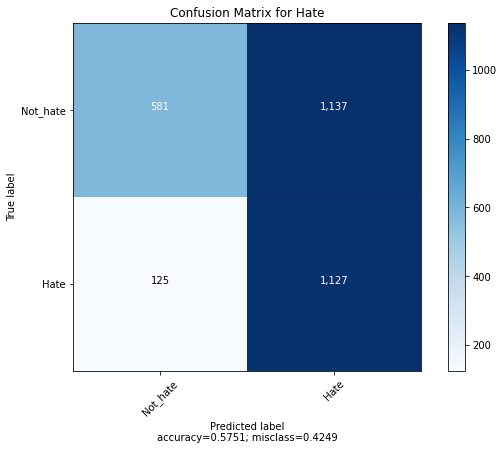

In [12]:
hate_pred_dl_label = [i[0] for i in preds_dl_hate.round().astype(int)]
cm = confusion_matrix(hate_dict_test.label,hate_pred_dl_label)
f1_dl_hate = f1_score(hate_dict_test.label,hate_pred_dl_label,average='macro')
print("F1_score of Hate dataset with DistilBert is: %.1f%%" % round(f1_dl_hate*100,1))
plot_confusion_matrix(cm, normalize=False,target_names=['Not_hate', 'Hate'],title="Confusion Matrix for Hate")

In [13]:
DistilBert_irony = create_model(dbert_model)
hist_irony = DistilBert_irony.fit(x=dl_irony_train_input, y=irony_dict_train.label, epochs=25, batch_size=16, validation_data=(dl_irony_val_input, irony_dict_val.label), callbacks=callbacks)

Epoch 1/25
178/178 [==============================] - 33s 146ms/step - loss: 0.7239 - accuracy: 0.5294 - precision_1: 0.5323 - recall_1: 0.6117 - val_loss: 0.6465 - val_accuracy: 0.6251 - val_precision_1: 0.5950 - val_recall_1: 0.6732
Epoch 2/25
178/178 [==============================] - 24s 137ms/step - loss: 0.5558 - accuracy: 0.7318 - precision_1: 0.7438 - recall_1: 0.7020 - val_loss: 0.6325 - val_accuracy: 0.6398 - val_precision_1: 0.6250 - val_recall_1: 0.6140
Epoch 3/25
178/178 [==============================] - 24s 137ms/step - loss: 0.3524 - accuracy: 0.8598 - precision_1: 0.8736 - recall_1: 0.8438 - val_loss: 0.6936 - val_accuracy: 0.6471 - val_precision_1: 0.6227 - val_recall_1: 0.6623
Epoch 4/25
178/178 [==============================] - 24s 137ms/step - loss: 0.1666 - accuracy: 0.9460 - precision_1: 0.9447 - recall_1: 0.9478 - val_loss: 0.9464 - val_accuracy: 0.6304 - val_precision_1: 0.5970 - val_recall_1: 0.6952
Epoch 5/25
178/178 [==============================] - 24s 13

In [14]:
preds_dl_irony = DistilBert_irony.predict(dl_irony_test_input, verbose=True)

25/25 [==============================] - 3s 75ms/step


F1_score of irony dataset with DistilBert is: 61.8%


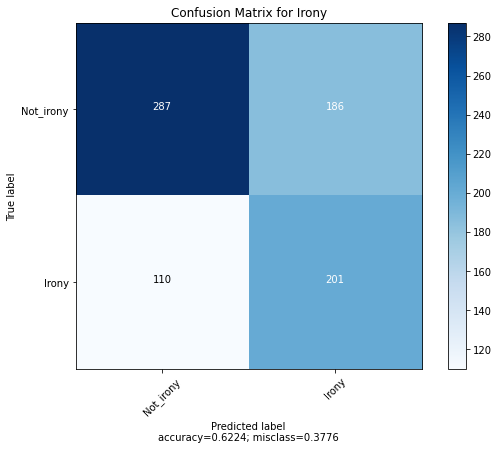

In [15]:
irony_pred_dl_label = [i[0] for i in preds_dl_irony.round().astype(int)]
cm = confusion_matrix(irony_dict_test.label,irony_pred_dl_label)
f1_dl_irony = f1_score(irony_dict_test.label,irony_pred_dl_label,average='macro')
print("F1_score of irony dataset with DistilBert is: %.1f%%" % round(f1_dl_irony*100,1))
plot_confusion_matrix(cm, normalize=False,target_names=['Not_irony', 'Irony'],title="Confusion Matrix for Irony")

In [16]:
DistilBert_offensive = create_model(dbert_model)
hist_dl_offensive = DistilBert_offensive.fit(x=dl_offensive_train_input, y=offensive_dict_train.label, epochs=25, batch_size=16, validation_data=(dl_offensive_val_input, offensive_dict_val.label), callbacks=callbacks)

Epoch 1/25
493/493 [==============================] - 73s 134ms/step - loss: 0.7068 - accuracy: 0.5130 - precision_2: 0.5112 - recall_2: 0.5071 - val_loss: 0.7024 - val_accuracy: 0.3467 - val_precision_2: 0.3467 - val_recall_2: 1.0000
Epoch 2/25
493/493 [==============================] - 64s 131ms/step - loss: 0.6903 - accuracy: 0.5190 - precision_2: 0.5137 - recall_2: 0.8227 - val_loss: 0.6270 - val_accuracy: 0.6813 - val_precision_2: 0.5504 - val_recall_2: 0.4401
Epoch 3/25
493/493 [==============================] - 64s 130ms/step - loss: 0.6265 - accuracy: 0.6412 - precision_2: 0.6520 - recall_2: 0.6048 - val_loss: 0.5890 - val_accuracy: 0.6858 - val_precision_2: 0.5408 - val_recall_2: 0.6209
Epoch 4/25
493/493 [==============================] - 64s 130ms/step - loss: 0.5284 - accuracy: 0.7423 - precision_2: 0.7705 - recall_2: 0.6958 - val_loss: 0.5763 - val_accuracy: 0.7190 - val_precision_2: 0.5978 - val_recall_2: 0.5795
Epoch 5/25
493/493 [==============================] - 64s 13

In [17]:
preds_dl_offensive = DistilBert_offensive.predict(dl_offensive_test_input, verbose=True)

27/27 [==============================] - 3s 77ms/step


F1_score of offensive dataset with DistilBert is: 64.9%


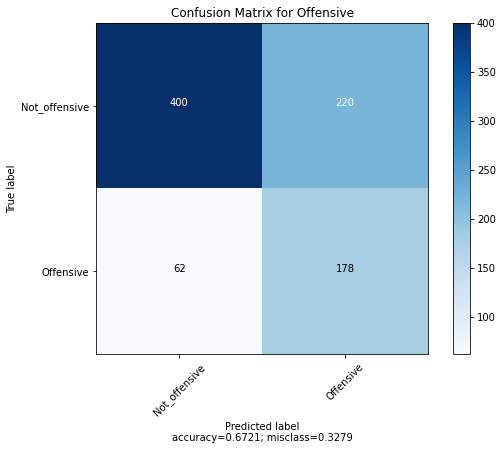

In [18]:
offensive_pred_dl_label = [i[0] for i in preds_dl_offensive.round().astype(int)]
cm = confusion_matrix(offensive_dict_test.label,offensive_pred_dl_label)
f1_dl_offensive = f1_score(offensive_dict_test.label,offensive_pred_dl_label,average='macro')
print("F1_score of offensive dataset with DistilBert is: %.1f%%" % round(f1_dl_offensive*100,1))
plot_confusion_matrix(cm, normalize=False, target_names=['Not_offensive', 'Offensive'],title="Confusion Matrix for Offensive")

#Apply XLNet as the 2nd model to predict classifcation.

In [19]:
XLNet_hate = create_model(xlnet_model)
XLNet_hate.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_ids (InputLayer)           [(None, 120)]        0                                            
__________________________________________________________________________________________________
word_attention (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
tfxl_net_model (TFXLNetModel)   TFXLNetModelOutput(l 116718336   word_ids[0][0]                   
                                                                 word_attention[0][0]             
__________________________________________________________________________________________________
tf.__operators__.getitem_3 (Sli (None, 1, 768)       0           tfxl_net_model[0][0]       

In [20]:
hist_xl_hate = XLNet_hate.fit(x=xl_hate_train_input, y=hate_dict_train.label, epochs=25, batch_size=16, validation_data=(xl_hate_val_input, hate_dict_val.label), callbacks=callbacks)

Epoch 1/25
473/473 [==============================] - 161s 314ms/step - loss: 0.7204 - accuracy: 0.5914 - precision_3: 0.5767 - recall_3: 0.6503 - val_loss: 0.6100 - val_accuracy: 0.6580 - val_precision_3: 0.5707 - val_recall_3: 0.8033
Epoch 2/25
473/473 [==============================] - 146s 310ms/step - loss: 0.5265 - accuracy: 0.7437 - precision_3: 0.7373 - recall_3: 0.7680 - val_loss: 0.5638 - val_accuracy: 0.7030 - val_precision_3: 0.6231 - val_recall_3: 0.7705
Epoch 3/25
473/473 [==============================] - 146s 310ms/step - loss: 0.4240 - accuracy: 0.8148 - precision_3: 0.8038 - recall_3: 0.8313 - val_loss: 0.6758 - val_accuracy: 0.6650 - val_precision_3: 0.5708 - val_recall_3: 0.8689
Epoch 4/25
473/473 [==============================] - 146s 309ms/step - loss: 0.3321 - accuracy: 0.8582 - precision_3: 0.8422 - recall_3: 0.8788 - val_loss: 0.6133 - val_accuracy: 0.7210 - val_precision_3: 0.6418 - val_recall_3: 0.7845
Epoch 5/25
473/473 [==============================] - 14

In [21]:
preds_xl_hate = XLNet_hate.predict(xl_hate_test_input, verbose=True)

93/93 [==============================] - 19s 185ms/step


F1_score of Hate dataset with DistilBert is: 56.3%


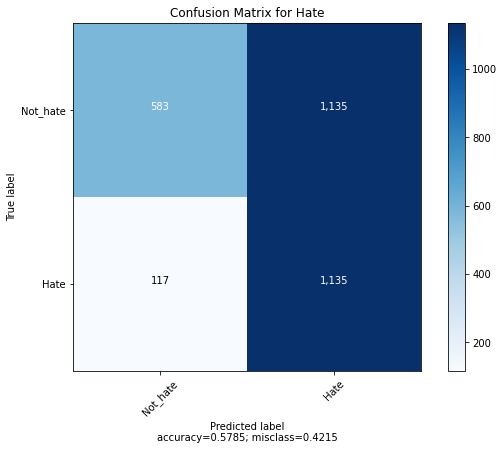

In [22]:
hate_pred_xl_label = [i[0] for i in preds_xl_hate.round().astype(int)]
cm = confusion_matrix(hate_dict_test.label,hate_pred_xl_label)
f1_xl_hate = f1_score(hate_dict_test.label,hate_pred_xl_label,average='macro')
print("F1_score of Hate dataset with XLnet is: %.1f%%" % round(f1_xl_hate*100,1))
plot_confusion_matrix(cm, normalize=False,target_names=['Not_hate', 'Hate'],title="Confusion Matrix for Hate")

In [23]:
XLNet_irony = create_model(xlnet_model)

In [24]:
hist_xl_irony = XLNet_irony.fit(x=xl_irony_train_input, y=irony_dict_train.label, epochs=25, batch_size=16, validation_data=(xl_irony_val_input, irony_dict_val.label), callbacks=callbacks)

Epoch 1/25
178/178 [==============================] - 72s 340ms/step - loss: 0.7409 - accuracy: 0.5170 - precision_4: 0.5140 - recall_4: 0.5243 - val_loss: 0.6917 - val_accuracy: 0.5372 - val_precision_4: 0.5086 - val_recall_4: 0.9079
Epoch 2/25
178/178 [==============================] - 58s 329ms/step - loss: 0.6438 - accuracy: 0.6334 - precision_4: 0.6111 - recall_4: 0.7233 - val_loss: 0.6879 - val_accuracy: 0.6094 - val_precision_4: 0.5636 - val_recall_4: 0.8070
Epoch 3/25
178/178 [==============================] - 58s 329ms/step - loss: 0.5110 - accuracy: 0.7630 - precision_4: 0.7767 - recall_4: 0.7388 - val_loss: 0.8371 - val_accuracy: 0.5948 - val_precision_4: 0.5483 - val_recall_4: 0.8596
Epoch 4/25
178/178 [==============================] - 58s 328ms/step - loss: 0.3959 - accuracy: 0.8419 - precision_4: 0.8488 - recall_4: 0.8177 - val_loss: 0.8201 - val_accuracy: 0.6482 - val_precision_4: 0.6091 - val_recall_4: 0.7346
Epoch 5/25
178/178 [==============================] - 58s 32

In [25]:
preds_xl_irony = XLNet_irony.predict(xl_irony_test_input, verbose=True)

25/25 [==============================] - 6s 182ms/step


F1_score of irony dataset with DistilBert is: 62.6%


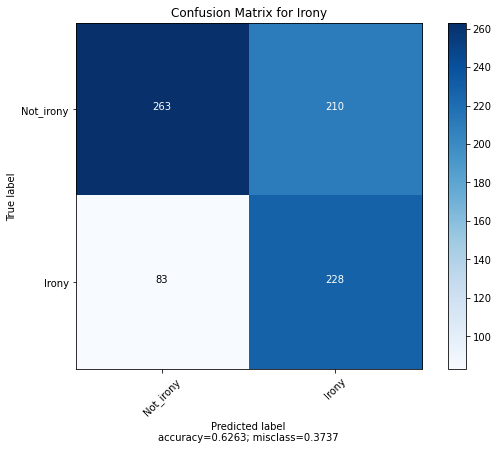

In [26]:
irony_pred_xl_label = [i[0] for i in preds_xl_irony.round().astype(int)]
cm = confusion_matrix(irony_dict_test.label,irony_pred_xl_label)
f1_xl_irony = f1_score(irony_dict_test.label,irony_pred_xl_label,average='macro')
print("F1_score of irony dataset with DistilBert is: %.1f%%" % round(f1_xl_irony * 100,1))
plot_confusion_matrix(cm, normalize=False,target_names=['Not_irony', 'Irony'],title="Confusion Matrix for Irony")

In [27]:
XLNet_offensive = create_model(xlnet_model)

In [28]:
hist_xl_offensive = XLNet_offensive.fit(x=xl_offensive_train_input, y=offensive_dict_train.label, epochs=25, batch_size=16, validation_data=(xl_offensive_val_input, offensive_dict_val.label), callbacks=callbacks)

Epoch 1/25
493/493 [==============================] - 169s 318ms/step - loss: 0.6907 - accuracy: 0.5932 - precision_5: 0.5914 - recall_5: 0.6193 - val_loss: 0.5016 - val_accuracy: 0.7779 - val_precision_5: 0.6846 - val_recall_5: 0.6667
Epoch 2/25
493/493 [==============================] - 154s 313ms/step - loss: 0.4643 - accuracy: 0.7977 - precision_5: 0.8039 - recall_5: 0.7886 - val_loss: 0.5337 - val_accuracy: 0.7560 - val_precision_5: 0.6076 - val_recall_5: 0.8366
Epoch 3/25
493/493 [==============================] - 154s 313ms/step - loss: 0.3464 - accuracy: 0.8578 - precision_5: 0.8639 - recall_5: 0.8503 - val_loss: 0.5947 - val_accuracy: 0.7273 - val_precision_5: 0.5740 - val_recall_5: 0.8279
Epoch 4/25
493/493 [==============================] - 154s 313ms/step - loss: 0.2142 - accuracy: 0.9218 - precision_5: 0.9201 - recall_5: 0.9264 - val_loss: 0.7180 - val_accuracy: 0.7409 - val_precision_5: 0.5980 - val_recall_5: 0.7712
Epoch 5/25
493/493 [==============================] - 15

In [29]:
preds_xl_offensive = XLNet_offensive.predict(xl_offensive_test_input, verbose=True)

27/27 [==============================] - 7s 185ms/step


F1_score of offensive dataset with DistilBert is: 75.9%


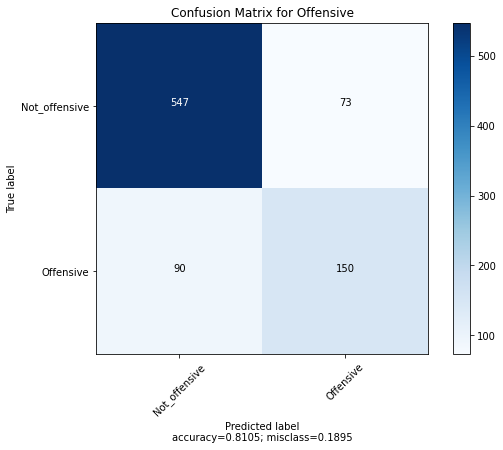

In [30]:
offensive_pred_xl_label = [i[0] for i in preds_xl_offensive.round().astype(int)]
cm = confusion_matrix(offensive_dict_test.label,offensive_pred_xl_label)
f1_xl_offensive = f1_score(offensive_dict_test.label,offensive_pred_xl_label,average='macro')
print("F1_score of offensive dataset with XLNET is: %.1f%%" % round(f1_xl_offensive * 100,1))
plot_confusion_matrix(cm, normalize=False,target_names=['Not_offensive', 'Offensive'],title="Confusion Matrix for Offensive")

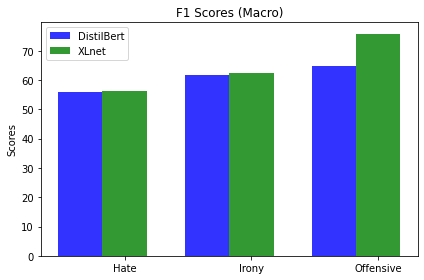

In [33]:
f1_score_bar(f1_dl_hate,f1_dl_irony,f1_dl_offensive,f1_xl_hate,f1_xl_irony,f1_xl_offensive)    

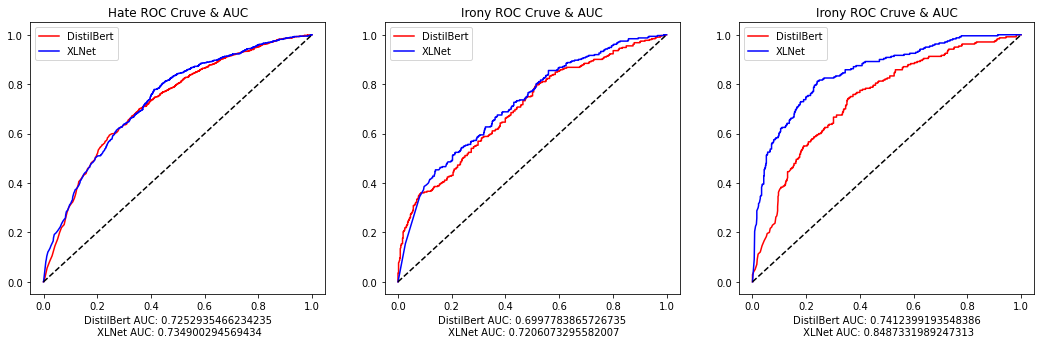

In [84]:
def auc_plot_metrics(hate_pred_dl,hate_pred_xl,hate_true_labels,irony_pred_dl,irony_pred_xl,irony_true_labels,offensive_pred_dl,offensive_pred_xl,offensive_true_labels):
    """Plots a ROC curve with the accuracy and the AUC"""
    fpr, tpr, thresholds = roc_curve(hate_true_labels, hate_pred_dl)
    fpr2, tpr2, thresholds2 = roc_curve(hate_true_labels, hate_pred_xl)
    auc_dl_hate = roc_auc_score(hate_true_labels, hate_pred_dl)
    auc_xl_hate = roc_auc_score(hate_true_labels, hate_pred_xl)

    fpr3, tpr3, thresholds3 = roc_curve(irony_true_labels, irony_pred_dl)
    fpr4, tpr4, thresholds4 = roc_curve(irony_true_labels, irony_pred_xl)
    auc_dl_irony = roc_auc_score(irony_true_labels, irony_pred_dl)
    auc_xl_irony = roc_auc_score(irony_true_labels, irony_pred_xl)

    fpr5, tpr5, thresholds5 = roc_curve(offensive_true_labels, offensive_pred_dl)
    fpr6, tpr6, thresholds6 = roc_curve(offensive_true_labels, offensive_pred_xl)
    auc_dl_offensive = roc_auc_score(offensive_true_labels, offensive_pred_dl)
    auc_xl_offensive = roc_auc_score(offensive_true_labels, offensive_pred_xl)

    fig, ax = plt.subplots(1,3)
    fig.set_figheight(5)
    fig.set_figwidth(18)

    ax[0].plot(fpr, tpr, color='red',label='DistilBert')
    ax[0].plot(fpr2, tpr2, color='blue',label='XLNet')
    ax[0].legend()
    ax[0].plot([0,1], [0,1], color='black', linestyle='--')
    ax[0].set_title(f"Hate ROC Cruve & AUC");
    ax[0].set_xlabel(f"DistilBert AUC: {auc_dl_hate}\n XLNet AUC: {auc_xl_hate}")

    ax[1].plot(fpr3, tpr3, color='red',label='DistilBert')
    ax[1].plot(fpr4, tpr4, color='blue',label='XLNet')
    ax[1].legend()
    ax[1].plot([0,1], [0,1], color='black', linestyle='--')
    ax[1].set_title(f"Irony ROC Cruve & AUC");
    ax[1].set_xlabel(f"DistilBert AUC: {auc_dl_irony}\n XLNet AUC: {auc_xl_irony}")

    ax[2].plot(fpr5, tpr5, color='red',label='DistilBert')
    ax[2].plot(fpr6, tpr6, color='blue',label='XLNet')
    ax[2].legend()
    ax[2].plot([0,1], [0,1], color='black', linestyle='--')
    ax[2].set_title(f"Irony ROC Cruve & AUC");
    ax[2].set_xlabel(f"DistilBert AUC: {auc_dl_offensive}\n XLNet AUC: {auc_xl_offensive}")

auc_plot_metrics(preds_dl_hate, preds_xl_hate, hate_dict_test.label,
         preds_dl_irony, preds_xl_irony, irony_dict_test.label,
         preds_dl_offensive, preds_xl_offensive, offensive_dict_test.label)